In [3]:
#Setup Code

import csv
import warnings
import pickle
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice, chain, count, product
from contextlib import nullcontext
from concurrent.futures import ProcessPoolExecutor

data_dir = "../data"

import torch
import torch.utils.data
import coba as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from parameterfree import COCOB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

try:
    torch.set_num_threads(3)
    torch.set_num_interop_threads(3)
except RuntimeError:
    pass

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

torch.set_default_device('cpu')
plt.rc('font', **{'size': 20})

def make_emotions_df():

    def add_day_columns(df, timestamp_col, participant_df):
        return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

    def add_day(df, timestamp_col):
        df = df.copy()
        df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
        return df

    def add_start_day(df, participant_df):
        participant_df = participant_df.copy()
        participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
        return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

    def add_rel_day(df):
        df = df.copy()
        df["RelDay"] = df["Day"]-df["StartDay"]
        return df

    def drop_all1_ends(df):
        last, last_gt_1, keep = df.copy(),df.copy(), df.copy()
        
        last_gt_1 = last_gt_1[last_gt_1["State Anxiety"]!= 1]
        last_gt_1 = last_gt_1.groupby("ParticipantId")["RelDay"].max().reset_index()
        last_gt_1 = last_gt_1.rename(columns={"RelDay":"Last Day > 1"})

        last = last.groupby("ParticipantId")["RelDay"].max().reset_index()
        last = last.rename(columns={"RelDay":"Last Day"})

        for pid in last["ParticipantId"]:
            
            last_day = last[last["ParticipantId"]==pid]["Last Day"].item()
            last_day_gt_1 = last_gt_1[last_gt_1["ParticipantId"]==pid]["Last Day > 1"].item()
            
            if last_day-last_day_gt_1 >= 3:
                is_not_pid = keep["ParticipantId"] != pid
                is_lt_day  = keep["RelDay"] <= last_day_gt_1
                keep = keep[is_not_pid | is_lt_day]

        return keep

    emotions_df = pd.read_csv(f'{data_dir}/Emotions.csv')
    participant_df = pd.read_csv(f'{data_dir}/Participants.csv')

    emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

    emotions_df["State Anxiety"] = pd.to_numeric(emotions_df["State Anxiety"], errors='coerce')
    emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
    emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
    emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60
    emotions_df["Response Time (sec)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])
    emotions_df["Response Time (log min)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60)
    emotions_df["Response Time (log sec)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"]))

    emotions_df["State Anxiety (z)"] = float('nan')
    emotions_df["ER Interest (z)"] = float('nan')

    for pid in set(emotions_df["ParticipantId"].tolist()):
        is_pid = emotions_df["ParticipantId"] == pid
        is_anx = emotions_df["State Anxiety"] > 1
        emotions_df.loc[is_pid,["ER Interest (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid,["ER Interest"]])
        emotions_df.loc[is_pid&is_anx,["State Anxiety (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid&is_anx,["State Anxiety"]])

    emotions_df = add_day_columns(emotions_df, "DeliveredTimestampUtc", participant_df)

    emotions_df = emotions_df[emotions_df["RelDay"] < 11]

    return drop_all1_ends(emotions_df)

emotions_df = make_emotions_df()

class TheoryGridCellSpatialRelationEncoder:
    #https://arxiv.org/pdf/2003.00824
    def __init__(self, coord_dim = 2, frequency_num = 16, max_radius = 10000,  min_radius = 1000, freq_init = "geometric"):
        """
        Args:
            coord_dim: the dimention of space, 2D, 3D, or other
            frequency_num: the number of different sinusoidal with different frequencies/wavelengths
            max_radius: the largest context radius this model can handle
        """

        self.frequency_num = frequency_num
        self.coord_dim = coord_dim 
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.freq_init = freq_init

        # the frequency we use for each block, alpha in ICLR paper
        self.cal_freq_list()
        
        # freq_mat shape: (frequency_num, 1)
        freq_mat = np.expand_dims(self.freq_list, axis = 1)
        # self.freq_mat shape: (frequency_num, 6)
        self.freq_mat = np.repeat(freq_mat, 6, axis = 1)

        # there unit vectors which is 120 degree apart from each other
        self.unit_vec1 = np.asarray([1.0, 0.0])                        # 0
        self.unit_vec2 = np.asarray([-1.0/2.0, np.sqrt(3)/2.0])      # 120 degree
        self.unit_vec3 = np.asarray([-1.0/2.0, -np.sqrt(3)/2.0])     # 240 degree

        # compute the dimention of the encoded spatial relation embedding
        self.input_embed_dim = int(6 * self.frequency_num)
        
    def cal_freq_list(self):
        if self.freq_init == "random":
            self.freq_list = np.random.random(size=[self.frequency_num]) * self.max_radius
        elif self.freq_init == "geometric":
            log_timescale_increment = (np.log(float(self.max_radius) / float(self.min_radius)) /(self.frequency_num*1.0 - 1))
            timescales = self.min_radius * np.exp(np.arange(self.frequency_num).astype(float) * log_timescale_increment)
            self.freq_list = 1.0/timescales
        else:
            raise Exception()

    def make_input_embeds(self, coords):
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:
            coords = [[c] for c in coords]
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")

        # (batch_size, num_context_pt, coord_dim)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]

        # compute the dot product between [deltaX, deltaY] and each unit_vec 
        # (batch_size, num_context_pt, 1)
        angle_mat1 = np.expand_dims(np.matmul(coords_mat, self.unit_vec1), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat2 = np.expand_dims(np.matmul(coords_mat, self.unit_vec2), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat3 = np.expand_dims(np.matmul(coords_mat, self.unit_vec3), axis = -1)

        # (batch_size, num_context_pt, 6)
        angle_mat = np.concatenate([angle_mat1, angle_mat1, angle_mat2, angle_mat2, angle_mat3, angle_mat3], axis = -1)
        # (batch_size, num_context_pt, 1, 6)
        angle_mat = np.expand_dims(angle_mat, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = np.repeat(angle_mat, self.frequency_num, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = angle_mat * self.freq_mat
        # (batch_size, num_context_pt, frequency_num*6)
        spr_embeds = np.reshape(angle_mat, (batch_size, num_context_pt, -1))

        # make sinuniod function
        # sin for 2i, cos for 2i+1
        # spr_embeds: (batch_size, num_context_pt, frequency_num*6=input_embed_dim)
        spr_embeds[:, :, 0::2] = np.sin(spr_embeds[:, :, 0::2])  # dim 2i
        spr_embeds[:, :, 1::2] = np.cos(spr_embeds[:, :, 1::2])  # dim 2i+1
        
        return spr_embeds.squeeze().tolist()

def is_gt(values,val):
    out = (values > val).astype(float)
    out[values.isna()] = float('nan')
    return out

def is_lt(values,val):
    out = (values < val).astype(float)
    out[values.isna()] = float('nan')
    return out

def scale(values):
    with warnings.catch_warnings():
        # If a column has all nan then a warning is thrown
        # We supress that warning because that can happen
        warnings.simplefilter("ignore")
        return StandardScaler().fit_transform(values).tolist()

def add1(X):
    for x,z in zip(X,np.isnan(X).all(axis=1).astype(int)):
        x.append(z)
    return X

def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) >= timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def dems(pid, timestamps):
    df = pd.read_csv(f'{data_dir}/Baseline.csv')
    i = df["pid"].tolist().index(pid)
    return df.to_numpy()[[i]*len(timestamps), 1:].tolist()

def cacher(sensor,pid,ts,maker,*args):
    filename = f"{sensor}_{int(sum(ts))}_{args}_{pid}.pkl"
    features = load_feats(filename)
    if features: return features
    features = maker(pid,ts,*args)
    save_feats(filename,features)
    return features

def hrs(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/HeartRate.csv", timestamps, secs):
        w = list(filter(None,w))
        if w: features.append([np.mean(w),np.std(w)])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'hrs'
    return scale(features)

def scs1(pid, timestamps, secs):
    features = []
    if features: return features

    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'scs1'

    return scale(features)

def scs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
    assert len(set(map(len,features))) == 1, 'scs2'
    return scale(features)

def lins1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins1'
    return scale(features)

def lins2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def lins3(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins3'
    return scale(features)

def lins4(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def bats1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if len(w)==1: features.append([0,float('nan'),float('nan')])
        elif len(w)>1: features.append([np.max(w)-np.min(w),np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'bats1'
    return features

def bats2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if w: features.append([np.mean(w),np.max(w)-np.min(w)])
        else: features.append([float('nan')]*2)
        assert len(set(map(len,features))) == 1, 'bats2'
    return features

def peds1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)==1: features.append([float('nan'),0,float('nan')])
        elif len(w)>1: features.append([np.mean(np.diff(w)),np.max(w)-np.min(w),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'peds1'
    return scale(features)

def peds2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
        assert len(set(map(len,features))) == 1, 'peds2'
    return scale(features)

def locs1(pid, timestamps, secs, freq, lmin, lmax):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    out = TheoryGridCellSpatialRelationEncoder(frequency_num=freq,min_radius=lmin,max_radius=lmax,freq_init='geometric').make_input_embeds(features)
    return [out] if len(timestamps) == 1 else out

def locs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    return features

def tims(timestamps,tzs):
    hour, day = 60*60, 60*60*24
    for timestamp,tz in zip(timestamps,tzs):
        if np.isnan(timestamp): 
            yield [float('nan')]*3
        else:
            if   tz == "-04:00": timestamp -= 4*hour
            elif tz == "-05:00": timestamp -= 5*hour
            time_of_day = (timestamp/day) % 1
            day_of_week = (int(timestamp/day)+4) % 7
            is_weekend = day_of_week in [0,6]
            is_weekday = day_of_week in [1,2,3,4,5]
            yield [time_of_day,int(is_weekend),int(is_weekday)]

def save_feats(filename,feats):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        with open(f"{data_dir}/feats/{filename}", "wb") as f: # Use "wb" for binary write mode
            pickle.dump(feats, f)

def load_feats(filename):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        return None
    else:
        try:
            with open(f"{data_dir}/feats/{filename}", "rb") as f: # Use "wb" for binary write mode
                return pickle.load(f)
        except:
            Path(f"{data_dir}/feats/{filename}").unlink()
            return None

def make_xyg2(work_item):
    (pid,ts,tz,ys,args,secs) = work_item

    fs = []

    if secs == None:
        if args[1]: fs.append(list(cacher("hrs"  ,pid,ts,hrs  ,args[1])))
        if args[2]: fs.append(list(cacher("scs2" ,pid,ts,scs2 ,args[2])))
        if args[3]: fs.append(list(cacher("lins3",pid,ts,lins3,args[3])))
        if args[4]: fs.append(list(cacher("lins4",pid,ts,lins4,args[4])))
        if args[5]: fs.append(list(cacher("bats2",pid,ts,bats2,args[5])))
        if args[6]: fs.append(list(cacher("peds2",pid,ts,peds2,args[6])))
        if args[7]: fs.append(list(cacher("locs1",pid,ts,locs1,*args[7])))

        if args[9]:
            for f in fs: add1(f)

        if args[0]: fs.append(list(tims(ts,tz)))
        if args[8]: fs.append(list(dems(pid,ts)))

        _xs = [list(chain.from_iterable(feats)) for feats in zip(*fs)]
        _ys = list(ys)
        _gs = [pid]*len(ys)
    
    else:
        _xs,_ys,_gs = [],[],[]
        for sec in (secs or []):
            nts = [t+sec for t in ts]
            nxs,nys,ngs = make_xyg2((pid,nts,tz,ys,args,None))
            _xs += nxs
            _ys += nys
            _gs += ngs

    return _xs,_ys,_gs

can_predict = emotions_df.copy().sort_values(["ParticipantId","DeliveredTimestampUtc"])

def work_items(tims:bool,hrs:int,scs:int,lins1:int,lins2:int,bats:int,peds:int,locs1,dems:bool,add1:bool,event:str,secs=[0]):

    df = can_predict[~can_predict["SubmissionTimestampUtc"].isna()]

    if not isinstance(secs,(list,tuple)): secs = [secs]

    for pid in sorted(df["ParticipantId"].drop_duplicates().tolist()):
        ptc  = df[df.ParticipantId == pid]
        tss  = ptc["SubmissionTimestampUtc" if event == "sub" else "DeliveredTimestampUtc"].tolist() 
        tzs  = ptc["LocalTimeZone"].tolist()

        y0s = torch.tensor(is_gt(ptc["ER Interest (z)"],0).tolist())
        y1s = torch.tensor(is_lt(ptc['Response Time (min)'],10).tolist())
        y2s = torch.tensor(is_gt(ptc["State Anxiety (z)"],0).tolist())
        y3s = torch.tensor(is_gt(ptc["State Anxiety"], 1).tolist())
        y4s = torch.tensor(ptc["Response Time (log sec)"].tolist())
        y5s = torch.tensor(ptc["ER Interest (z)"].tolist())
        y6s = torch.tensor(ptc["State Anxiety (z)"].tolist())

        ys = torch.hstack((
            y0s.unsqueeze(1),
            y1s.unsqueeze(1),
            y2s.unsqueeze(1),
            y3s.unsqueeze(1),
            y4s.unsqueeze(1),
            y5s.unsqueeze(1),
            y6s.unsqueeze(1)
        )).tolist()

        args = [tims,hrs,scs,lins1,lins2,bats,peds,locs1,dems,add1]

        yield pid,tss,tzs,ys,args,secs

#with ProcessPoolExecutor(max_workers=20) as executor:
X,Y,G = zip(*map(make_xyg2, work_items(True,0,0,300,0,300,300,[300,2,1,2],False,True,"del")))

Y = torch.tensor(list(chain.from_iterable(Y))).float()
G = torch.tensor(list(chain.from_iterable(G))).int()
G = G[~torch.isnan(Y[:,[0,1]]).any(dim=1)]

testable_G = cb.CobaRandom(1).shuffle([k for k,n in Counter(G.tolist()).items() if n >= 30])

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G

        X,Y,G = zip(*map(make_xyg2, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ssl_samps, ssl_negs, ssl_tau, ssl_v, ws_steps0, ws_drop0, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, weighted):

        self.s1  = s1  #dae
        self.s2  = s2  #ssl
        self.s3  = s3  #basis

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ssl_samps = ssl_samps
        self.ssl_negs  = ssl_negs
        self.ssl_tau   = ssl_tau
        self.ssl_v     = ssl_v

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl

        self.weighted = weighted

        self.params = { 's1': s1, 's2': s2, 's3': s3, 'dae': (dae_steps,dae_dropn), 'ssl': (ssl_samps,ssl_negs,ssl_tau,ssl_v), 'ws': (ws_steps0,ws_drop0), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl), 'weighted': weighted }

    def evaluate(self, env, lrn):

        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())

        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def sslv1(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))
            
            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}

            for g in set(G):
                Xg[g] = list(compress(X,map(eq,G,repeat(g))))
                Yg[g] = list(compress(Y,map(eq,G,repeat(g))))

            eq_class  = {y: list(compress(X,map(eq,Y,repeat(y)))) for y in set(Y)}
            ne_class  = {y: list(compress(X,map(ne,Y,repeat(y)))) for y in set(Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []
                for g in set(G):
                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[y],i))
                    negative.append(choose_n     (ne_class[y],nnegs))
                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def sslv2(X,Y,G,nsamps,nnegs):
            from itertools import compress, repeat, chain
            from operator import eq, ne

            rng = cb.CobaRandom(1)
            rng_order = rng.shuffle(range(len(X)))

            X = X.tolist()
            Y = list(map(tuple,Y.tolist()))
            G = G.tolist()

            X = list(map(X.__getitem__,rng_order))
            Y = list(map(Y.__getitem__,rng_order))
            G = list(map(G.__getitem__,rng_order))

            Xg = {}
            Yg = {}
            eq_class = {}
            ne_class = {}

            for g in set(G):
                _X = list(compress(X,map(eq,G,repeat(g))))
                _Y = list(compress(Y,map(eq,G,repeat(g))))

                Xg[g] = _X
                Yg[g] = _Y

                eq_class[g] = {y: list(compress(_X,map(eq,_Y,repeat(y)))) for y in set(_Y)}
                ne_class[g] = {y: list(compress(_X,map(ne,_Y,repeat(y)))) for y in set(_Y)}

            def choose_unique(items,given_i):
                if len(items) == 1:  return items[0]
                for i in rng.randints(100,0,len(items)-1):
                    if i != given_i:
                        return items[i]

            def choose_n(items,n):
                add_to_index = (indexes := set()).add if len(items) > n else (indexes := []).append
                for i in rng.randints(100,0,len(items)-1):
                    add_to_index(i)
                    if len(indexes)==n:
                        return [items[i] for i in indexes]

            for i in range(nsamps):
                anchor, positive, negative = [], [], []    
                for g in rng.shuffle(set(G)):
                    if len(set(Yg[g])) == 1: continue

                    x,y = Xg[g][i%len(Xg[g])],Yg[g][i%len(Yg[g])]
                    anchor.append(x)
                    positive.append(choose_unique(eq_class[g][y],i%len(Yg[g])))
                    negative.append(choose_n     (ne_class[g][y],nnegs))

                yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

        def get_scores(env):

            X,Y,G = env.get_data()

            if len(X) == 0: return

            g = env.g
            Y = Y[:,env.L]

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            def replace_x(layers):
                new_layers = []
                for l in layers:
                    if l == 'x': new_layers.append(n_feats)
                    elif l == '-x': new_layers.append(n_feats*n_persons)
                    elif isinstance(l,(tuple,list)): new_layers.append(replace_x(l))
                    else: new_layers.append(l)
                return new_layers

            _s1 = replace_x(self.s1)
            _s2 = replace_x(self.s2)
            _s3 = replace_x(self.s3)

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s3 and _s3[-1] == -1: _s3 = (*(_s3)[:-1], n_persons*n_tasks)

            s1 = FeedForward(_s1)
            s2 = FeedForward(_s2)
            s3 = FeedForward(_s3)

            s1_children = list(s1.children())
            s3_children = list(s3.children())

            sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
            s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

            sb = torch.nn.Sequential(*s3_children[len(s3_children)-self.ws_drop0:])
            s3 = torch.nn.Sequential(*s3_children[:len(s3_children)-self.ws_drop0])

            s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
            saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
            s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
            s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None
            sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None

            mods = [s1,sa,s2,s3,sb]
            opts = [s1opt,saopt,s2opt,s3opt,sbopt]

            for m in mods: m.train()

            if not isinstance(lrn,(cb.RandomLearner,cb.FixedLearner)):

                [s1,sa,s2,s3,sb] = mods
                [s1opt,saopt,s2opt,s3opt,sbopt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ssl_samps:
                    X, Y, G = trn_X,trn_Y,trn_G

                    if self.ssl_negs == 0: raise Exception("neg can't be 0")
                    if self.ssl_tau == 0: raise Exception("Tau can't be 0")

                    ssl = sslv1 if self.ssl_v == 1 else sslv2

                    for A,P,N in ssl(X, Y, G, self.ssl_samps, self.ssl_negs):
                        torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=4,drop_last=False,shuffle=True)

                        for _A, _P, _N in torch_loader:
                            #https://arxiv.org/pdf/2002.05709
                            _A = s2(s1(_A.nan_to_num()))
                            _P = s2(s1(_P.nan_to_num()))
                            _N = s2(s1(_N.nan_to_num()))

                            p = torch.einsum("bi,bi->b",_A,_P)
                            n = torch.einsum("bi,bji->bj",_A,_N)

                            p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                            n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                            p = torch.exp(p/self.ssl_tau)
                            n = torch.exp(n/self.ssl_tau)

                            if s2opt: s2opt.zero_grad()
                            (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                            if s2opt: s2opt.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,s3opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s3[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s3(s2(s1(_X.nan_to_num()))))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

            for m in mods: m.eval()

            rng = cb.CobaRandom(seed=env.params['rng'])
            rng_indexes = rng.shuffle(range(len(tst_X)))
            X,Y = tst_X[rng_indexes], tst_Y[rng_indexes]

            mems = []
            lrns = []

            learner = lrn
            send, nosend = (1,0), (0,1)

            for i in range(len(X)):

                #(1,0) send a notification
                #(0,1) don't send a notification

                [s1,_,s2,s3,_] = mods

                with torch.no_grad():
                    x,y = s3(s2(s1(X[i,:].nan_to_num()))).tolist(), float(Y[i,:].all())

                a, p = learner.predict(x, [send, nosend])
                r = (2*y-1) if a == send else 0

                yield {'context':x, 'action':a, 'reward':r}

                lrns.append((x,a,r,p))

                if self.pers_mem_cnt:
                    mems.append([x,a,r,1,self.pers_mem_rpt])

                if len(mems) > self.pers_mem_cnt:
                    rng.shuffle(mems, inplace=True)
                    for j in reversed(range(self.pers_mem_rcl)):
                        if j >= len(mems): continue
                        x,a,r,p,n = mems[j]
                        learner.learn(x,a,r,p)
                        if n == 1: mems.pop(j)
                        else: mems[j] = [x,a,r,p,n-1]

                if len(lrns) >= self.pers_lrn_cnt:
                    for x,a,r,p in lrns[:self.pers_lrn_cnt]:
                        learner.learn(x,a,r,p)
                    del lrns[:self.pers_lrn_cnt]

        yield from get_scores(env)

#a = (True, 0, 300, 300, 300, 0  , 0, 300, False, True, 'del') #for [1]
a = (True, 0, 300, 0, 300, 300, 300, 300, False, True, 'del') #for [0,1]

envs = [ MyEnvironment(a,[0,1],[g],rng) for g in testable_G for rng in range(8) ]
lrns = [ cb.LinUCBLearner(), cb.RandomLearner(), cb.FixedLearner([1,0]) ]
vals = [
    # ssl (v=2) + basis
    MyEvaluator((), ('x','l','r',40,'l','r',90), (90,'l','r',-1), 0, 0, 120, 4, .5, 2, 4, 1, 1, 2, 2, 2, []),
]

res = cb.Experiment(envs,lrns,vals).run(processes=25,quiet=True) #type: ignore
res.plot_learners()

We shortened 864 learner evaluations because they were longer than the shortest environment.


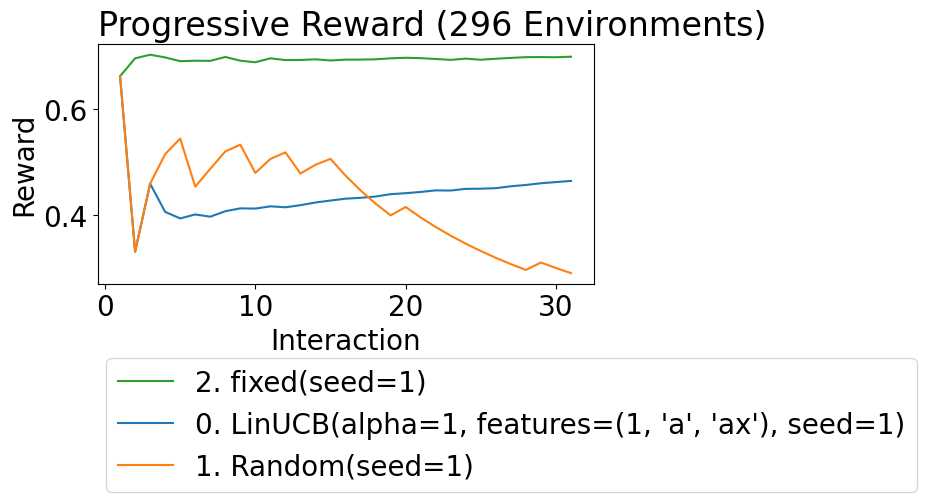

In [12]:
res.plot_learners()